Find the link to the data files:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
print('train_data:', train_data.shape)
print('test_data:', test_data.shape)

train_data: (159571, 8)
test_data: (153164, 2)


In [6]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [3]:
train_data['neutral'] = 1 - train_data[list(train_data.columns)[2:]].max(axis=1)

In [8]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [9]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='comment_text'>

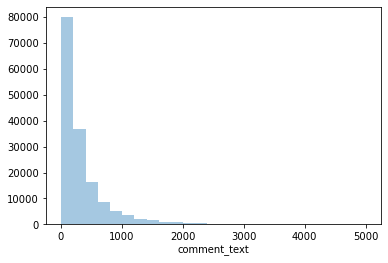

In [10]:
sns.distplot(train_data.comment_text.str.len(), kde=False, bins=25)

<AxesSubplot:>

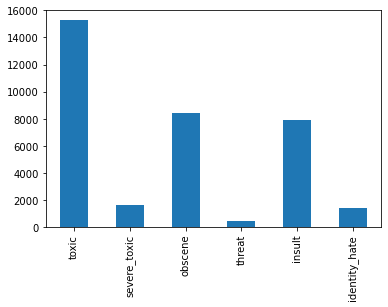

In [11]:
train_data[(train_data.columns)[2:-1]].sum().plot(kind='bar')

In [13]:
def plot_cloud(wordcloud):
    threat_context = train_data[train_data[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

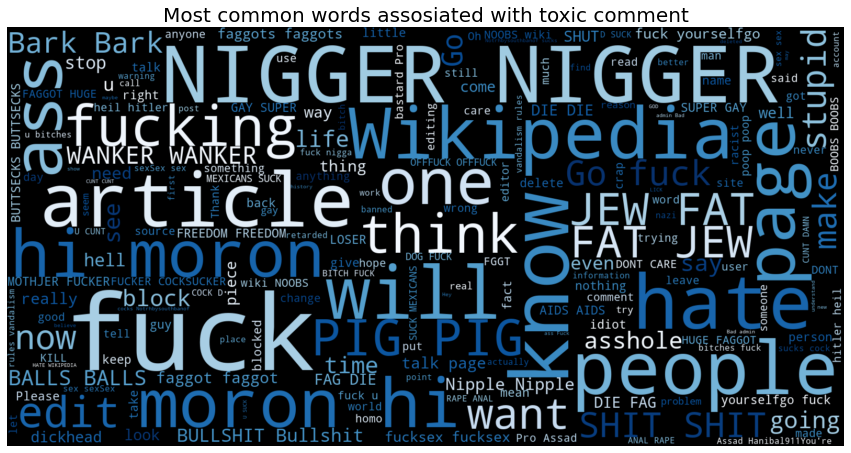

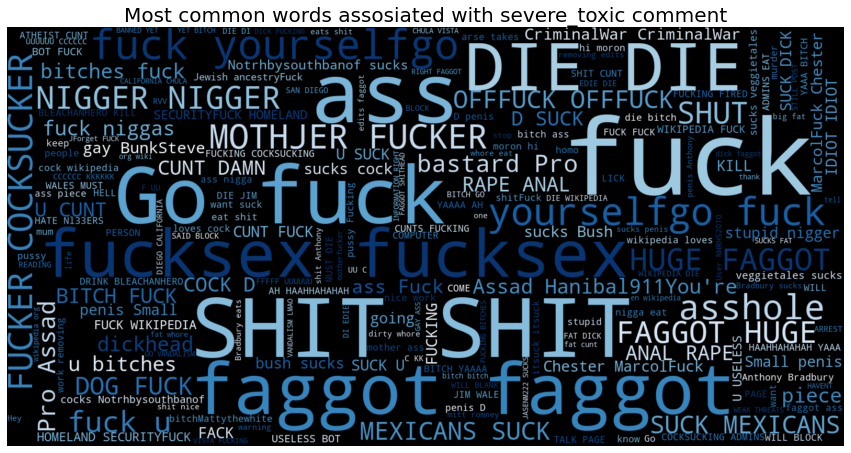

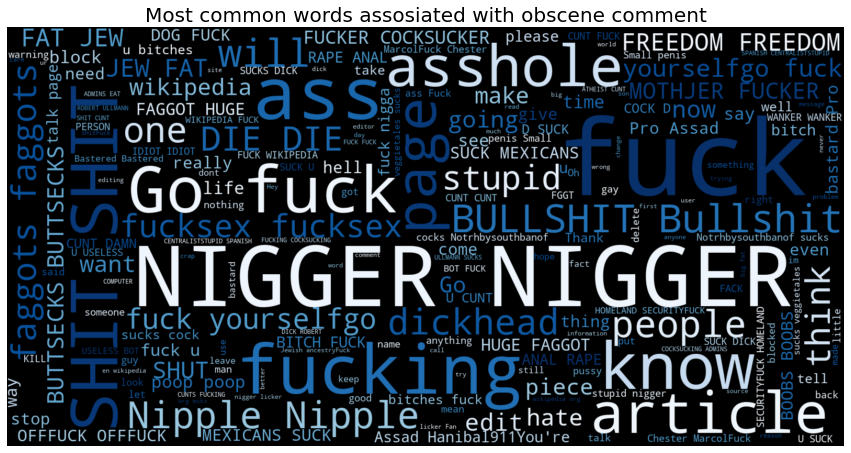

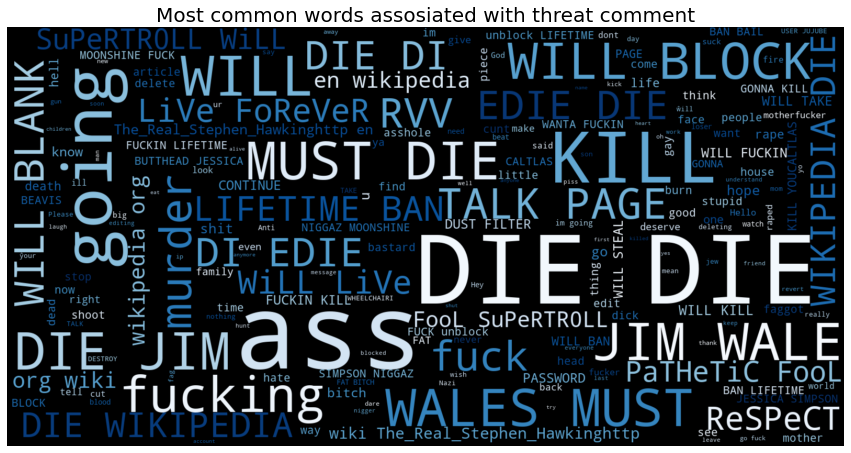

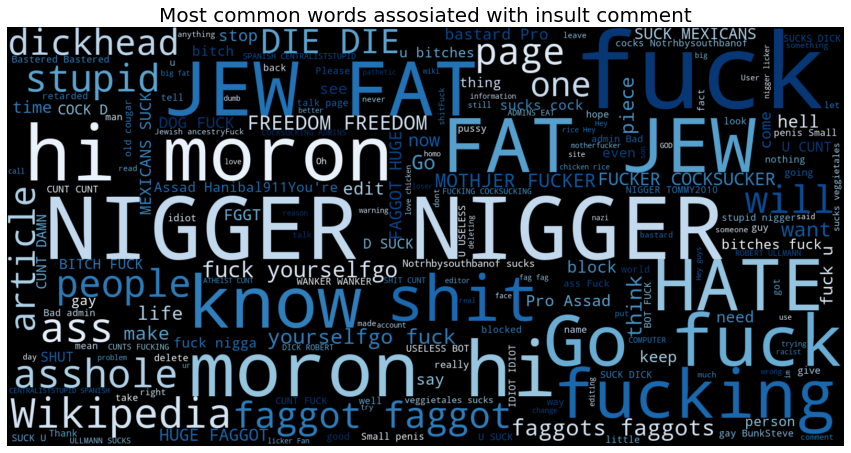

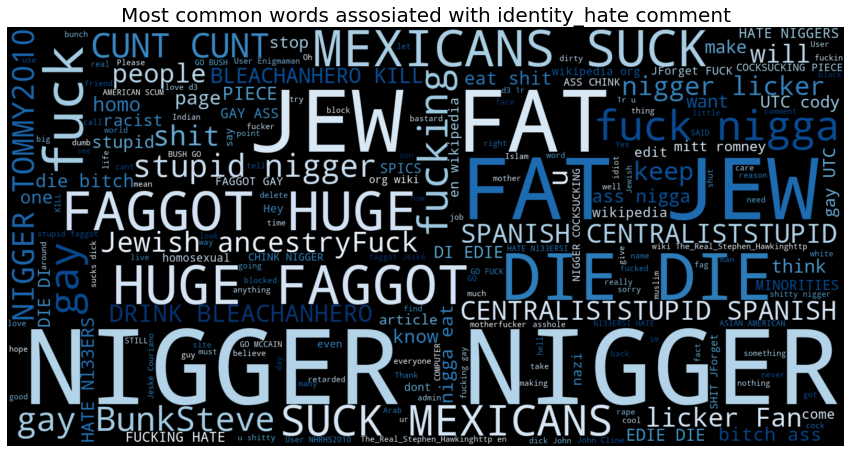

In [14]:
# token = input('Choose a class to visualize the most common words contributing to the class:')
for token in train_data.columns[2:-1]:
    plot_cloud(token.lower())

### Text Preprocessing

In [16]:
# train_data.loc[:, 'comment_text'] = train_data.loc[:, 'comment_text'].apply(lambda x: x.lower())
# train_data.loc[:, 'comment_text'] = train_data.loc[:, 'comment_text'].apply(lambda x: x.translate(str.maketrans(dict.fromkeys(string.punctuation))))
# train_data.loc[:, 'comment_text'] = train_data.loc[:, 'comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in stopwords.words('english')]))
# train_data.loc[:, 'comment_text'] = train_data.loc[:, 'comment_text'].apply(lambda x: re.sub(r'\d', '', x))
# train_data.head()

In [4]:
# Convert to lowercase
train_data['comment_text'] = train_data['comment_text'].str.lower()
test_data['comment_text'] = test_data['comment_text'].str.lower()

In [5]:
# Remove punctuations, numbers, special characters, etc.
train_data['comment_text'] = train_data['comment_text'].str.replace('[^a-zA-Z\s]', '')
test_data['comment_text'] = test_data['comment_text'].str.replace('[^a-zA-Z\s]', '')

In [6]:
# Remove stopwords
stop = stopwords.words('english')
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in stop]))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in stop]))

In [7]:
# Remove most frequent and most rare words
cnt = Counter()
for text in (pd.concat([train_data, test_data])).comment_text.values:
    for word in text.split():
        cnt[word] += 1

freq_words = cnt.most_common(10)
rare_words = cnt.most_common()[-11:-1]

In [22]:
freq_words

[('article', 101863),
 ('page', 77829),
 ('wikipedia', 61931),
 ('would', 54015),
 ('like', 52291),
 ('one', 51800),
 ('please', 51297),
 ('dont', 48490),
 ('talk', 44218),
 ('see', 39392)]

In [23]:
rare_words

[('statmho', 1),
 ('maungaturoto', 1),
 ('acousmaticmusic', 1),
 ('withought', 1),
 ('plainsong', 1),
 ('notaion', 1),
 ('httpwikimediafoundationorgwikipressreleasesenglishwikipediaannouncesthousandthfeaturedarticle',
  1),
 ('dongmyeong', 1),
 ('toolongcrap', 1),
 ('eezs', 1)]

In [8]:
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in freq_words]))
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words]))

test_data['comment_text'] = test_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in freq_words]))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words]))

In [10]:
# Lemmatization
lemma = WordNetLemmatizer()
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))

In [11]:
train_data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0,1
5,00025465d4725e87,congratulation well use tool well talk,0,0,0,0,0,0,1
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,0
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,1
8,00037261f536c51d,sorry word nonsense offensive anyway im intend...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,1


In [29]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful youll ever whats ha...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,dont anonymously edit article


In [12]:
labels = list(train_data.columns[2:])
labels

['toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'neutral']

### Train-Test Split

In [13]:
x = train_data['comment_text'].values
y = train_data.drop(['id','comment_text'], axis=1).values

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)

In [15]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [17]:
y_train.columns = labels
y_test.columns = labels

In [18]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [19]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


### TFIDF Vectorizer

In [71]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
test = vectorizer.transform(test_data['comment_text'])

In [21]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaah',
 'aaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaw',
 'aaaaai',
 'aaaaaups',
 'aaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaaso',
 'aaaawwww',
 'aaabbe',
 'aaaborderrightwidthpx',
 'aaaboyzhotmailcom',
 'aaages',
 'aaaghh',
 'aaah',
 'aaahhh',
 'aaahs',
 'aaai',
 'aaajade',
 'aaan',
 'aaand',
 'aaarrrgggh',
 'aaaww',
 'aaba',
 'aable',
 'aabove',
 'aac',
 'aacd',
 'aachen',
 'aachi',
 'aacs',
 'aadam',
 'aaddira',
 'aadil',
 'aadmi',
 'aadu',
 'aaee',
 'aaf',
 'aafabbdbeeacjpg',
 'aaffect',
 'aafia',
 'aafias',
 'aafiveaa',
 'aafs',
 'aagadu',
 'aage',
 'aagf',
 'aagin',
 'aah',
 'aahahahahahaha',
 'aahank',
 'aahbsw',
 'aahh',
 'aahil',
 'aahoa',
 'aai',
 'aajacksoniv',
 'aajonus',
 'aalborg',
 'aalexa',
 'aaliya',
 'aaliyah',
 'aaliyahs',
 'aals',
 'aalst',
 'aalvano',
 'aam',
 'aam

In [72]:
len(vectorizer.get_feature_names())

183657

### Naive Bayes Classifier

toxic
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28828
           1       0.99      0.16      0.28      3087

    accuracy                           0.92     31915
   macro avg       0.96      0.58      0.62     31915
weighted avg       0.93      0.92      0.89     31915

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31595
           1       0.00      0.00      0.00       320

    accuracy                           0.99     31915
   macro avg       0.49      0.50      0.50     31915
weighted avg       0.98      0.99      0.98     31915

obscene
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     30195
           1       1.00      0.10      0.19      1720

    accuracy                           0.95     31915
   macro avg       0.98      0.55      0.58     31915
weighted avg       0.95      0.95      0.93    

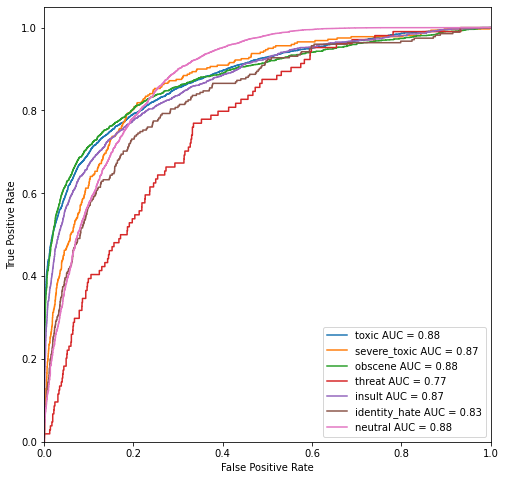

In [62]:
model_nb = MultinomialNB()

plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in labels:
    print(i)
    model_nb.fit(train_vectors, y_train[i])
    pred = model_nb.predict(test_vectors)
    prediction = model_nb.predict_proba(test_vectors)
    print(classification_report(y_test[i], pred))
#     print(confusion_matrix(y_test[i], pred))
    fpr, tpr, threshold = roc_curve(y_test[i], prediction[:,1])
    AUC = np.round(roc_auc_score(y_test[i], prediction[:,1]), 2)
    plt.plot(fpr, tpr, label=i+" AUC = "+str(AUC))
    plt.legend(loc="lower right")

In [84]:
pred_df = pd.DataFrame()
for i in labels[:-1]:
    model_nb.fit(train_vectors, y_train[i])
    pred_test = model_nb.predict(test)
    pred_df[i] = pred_test
pred_df.head()

toxic
severe_toxic
obscene
threat
insult
identity_hate


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [36]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 102C-9CE7

 Directory of C:\Users\Gaurab\Workspace\Capstone_Project\Toxic Comment Classification Challenge

15-02-2021  12:49    <DIR>          .
15-02-2021  12:49    <DIR>          ..
15-02-2021  12:49    <DIR>          .ipynb_checkpoints
12-02-2021  21:38        55,201,987 jigsaw-toxic-comment-classification-challenge.zip
19-06-2018  22:48         6,279,782 sample_submission.csv
19-01-2018  02:54        60,354,593 test.csv
19-06-2018  22:48         4,976,930 test_labels.csv
15-02-2021  12:48         2,850,126 Toxic_Comment_Classification.ipynb
15-02-2021  12:09         2,931,602 Toxic_Comment_Classification_old.ipynb
19-01-2018  02:54        68,802,655 train.csv
               7 File(s)    201,397,675 bytes
               3 Dir(s)  169,303,728,128 bytes free


In [85]:
sub_df = pd.read_csv('sample_submission.csv')
datasets = pd.concat([sub_df['id'],pred_df],axis=1)
datasets.to_csv('sample_submission.csv',index=False)

In [86]:
datasets

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0,0,0,0,0,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0,0,0,0,0,0
153160,fffd7a9a6eb32c16,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,0,0,0,0,0,0
153162,fffe8f1340a79fc2,0,0,0,0,0,0
